<a href="https://colab.research.google.com/github/saskiad/AMATH_BrainObservatory_Tutorial/blob/master/VisualCoding/1_Tuning_curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> This notebook walks us through how to compute a tuning curve using the Allen Brain Observatory Visual Coding data </h1>
    
A tuning curve summarizes a neuron's response to stimulus categories.

Here we will look at the responses of a neuron to the `Drifting Gratings` stimulus. This stimulus consists of a full-field sinusoidal grating that moves in a direction perpendicular to its orientation. As used in this experiment, the gratings move in eight different directions, spaced at 45° intervals, at a one of five different temporal frequencies (or speeds), ranging from 1 to 15 cycles/sec. The grating is presented for 2 seconds, followed by 1 second of mean luminance gray before the next trial begins. Each stimulus condition (direction + temporal frequency combination) is repeated 15 times in randomized order. In addition, there are "blanksweeps" (when the grating is replaced with 2 seconds of mean luminance gray) interleaved among the trials.



You can learn more about this stimulus and how we used it here: https://observatory.brain-map.org/visualcoding/stimulus/drifting_gratings

By comparing the responses of a neuron to each of these 40 conditions, we can characterize a number of that neuron's tuning properties, including orientation tuning, direction preference, and temporal frequency tuning.  



<br><img src="https://github.com/AllenInstitute/EducationAndEngagement/blob/main/VisualCoding/Directions.png?raw=1">

Our goal in this notebook is to use data from the Allen Brain Observatory Visual Coding dataset to calculate the responses of a neuron to this stimulus and compute its tuning curve. From there, we can compare its tuning properties with those of other neurons from the same experimental session, or from other sessions.

First, let's set up our environment to access the data:

In [1]:
# @title Run to initialize Allen Brain Observatory on Colab {display-mode: "form" }

# run only once per runtime/session, and only if running in colab
# the runtime will need to restxart after
%%capture
!apt install s3fs
!pip install allensdk
!mkdir -p /data/allen-brain-observatory/
!s3fs allen-brain-observatory /data/allen-brain-observatory/ -o public_bucket=1

import time
print("Runtime is now restarting...")
print("You can ignore the error message [Your session crashed for an unknown reason.]")
time.sleep(5)
exit()

### Standard imports
We're using standard python analysis packages to work with the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Allen Brain Observatory set up

This instantiates the tools in the Allen SDK that allow us to access the Brain Observatory data. We use the `BrainObservatoryCache` and point it to the `manifest_file` for this dataset.

In [2]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = '/data/allen-brain-observatory/visual-coding-2p/manifest.json'
boc = BrainObservatoryCache(manifest_file=manifest_file)

We'll look at one cell to start

In [3]:
cell_id = 541513979

### Access the data we need

The AllenSDK gives us access to all of the data available from this session. This includes max projection images, segmented masks for each neuron, raw fluorescence traces, DF/F ("Delta F over F") traces, stimulus tables and templates, the mouse's running speed, and more!

<p>In order to compute the tuning curve of the neuron, we need to access

1. the activity of the neuron.  We will use the DF/F trace.
2. stimulus information for the drifting grating stimulus

What is the DF/F trace? Raw fluorescence is difficult to interpret on its own for a variety of reasons. Here we've done a few processing steps into order to be able to better identify neural activity. First, we've subtracted contaminating neuropil signal from the raw fluorescence. This is just imaging noise from neighboring neurons that contaminates the signal. Second, we have normalized the fluorescence to it's baseline. We do that by dividing the change in fluorescence by the median of the fluorescence over a three second window preceding each time point. This gives us the change in fluorescence ("Delta F") normalized by baseline fluorescene ("over F").


Our goal today is to interact with data and not to learn the intricacies of the AllenSDK, so we have written the function below that uses the AllenSDK to get these pieces of data. It does so by first identifying which experiment session contains the specified cell id and stimulus. It then accesses the NWB file for that session and reads the DF/F trace for the specified cell and the stimulus table for the specified stimulus.
The function returns three things:
- timestamps
- dff trace for the specified neuron
- stimulus table for the specified stimulus

In [4]:
def get_dff_traces_and_stim_table(cell_specimen_id, stimulus):
    #identify the session for a given cell id and stimulus
    exps = boc.get_ophys_experiments(cell_specimen_ids=[cell_specimen_id], stimuli=[stimulus])

    #get the session_id for that session
    session_id = exps[0]['id']

    #access the data for that session
    data_set = boc.get_ophys_experiment_data(session_id)

    #get the DFF trace for the cell
    timestamps, dff = data_set.get_dff_traces(cell_specimen_ids=[cell_specimen_id])
    dff_trace = dff[0,:]

    #get the stimulus table for the stimulus
    stim_table = data_set.get_stimulus_table(stimulus)

    #return everything
    return (timestamps, dff_trace, stim_table)

In [5]:
timestamps, dff_trace, stim_table = get_dff_traces_and_stim_table(cell_id, 'drifting_gratings')

It is always good to look at the data objects you're working with to make sure you understand what they are. What is the shape of these different objects?

In [6]:
dff_trace.shape

(115741,)

In [7]:
timestamps.shape

(115741,)

In [8]:
stim_table.shape

(628, 5)

### DFF
Plot the DF/F trace of our neuron vs the timestamps to see what it looks like

Text(0, 0.5, 'DFF')

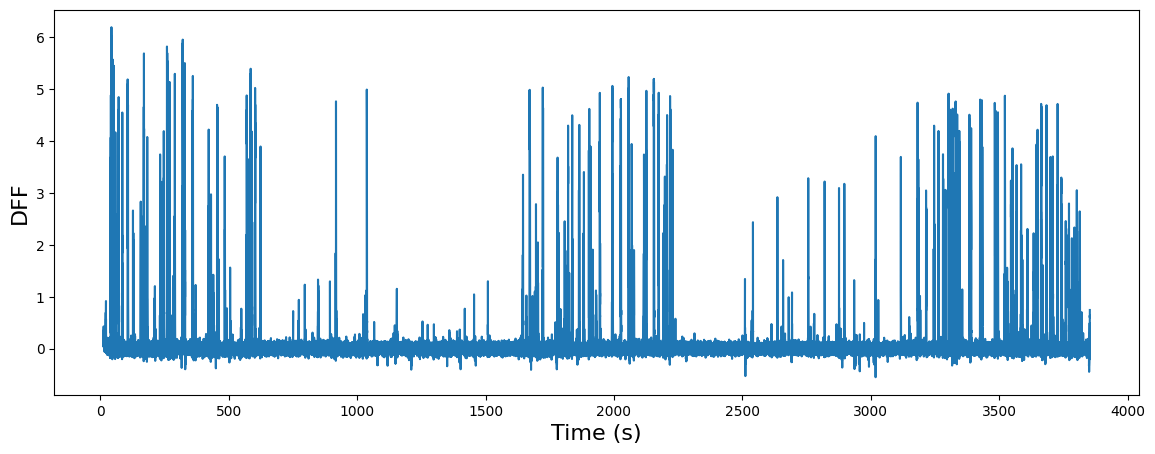

In [9]:
plt.figure(figsize=(14,5)) #create a figure
plt.plot(timestamps, dff_trace) #plot dff_trace vs timestamps
plt.xlabel("Time (s)", fontsize=16) #label xaxis
plt.ylabel("DFF", fontsize=16) #label yaxis

What do you notice about this neuron's activity?

### Stimulus Table
Now look at our stimulus table to see what information we have. This is a pandas DataFrame, and for now we just want to see the first few lines to understand what the structure is, so use the function <b>head</b> to see the top of this DataFrame.

In [ ]:
stim_table.head()

,temporal_frequency,orientation,blank_sweep,start,end
0,1.0,45.0,0.0,736,796
1,15.0,90.0,0.0,826,886
2,1.0,270.0,0.0,917,977
3,NaN,NaN,1.0,1007,1067
4,4.0,90.0,0.0,1098,1158


<div style="border-radius: 3px; padding: 10px;  background: #F0FAFF; ">

### Pandas
The stim_table you see above is a pandas DataFrame. This is a tabular data structure with labeled columns and rows.
<p>
To access data from a DataFrame we must specify the column using its name and specify the row using its <b>index</b>. To specify a column we can use two methods:
<li> stim_table['start']
<li> stim_table.start
<p> Then to specify the row of that column we want we must use the index of that row.
<li> stim_table['start'][0]
<li> stim_table.start[0]
<p> We can also subselect portions of the DataFrame using the values in the DataFrame. For example, to select only the rows of the table where the orientation is 90 degrees we can use:
<li> stim_table[stim_table.orientation==90]
<p>Pay attention when you do this as the subselected DataFrame maintain the indices of the original DataFrame. Now in order to get a specific row, you either need to know its original index, or use <b>iloc</b>. For example, this will return the first row of the subselected DataFrame regardless of the original index of that row:
<li> stim_table[stim_table.orientation==90].iloc[0]
</div>

The stimulus table for our drifting grating has 5 columns.  `start` and `end` indicate the <b>frame number</b> when a given trial starts and ends, respectively. The other columns indicate what the grating condition is for that trial, including the `temporal frequency` of the grating (in Hz), the direction (called `orientation`) of the grating (in degrees), and whether the grating is a `blank sweep` (eg. a gray screen).

# Task
How many unique temporal frequencies and orientations are there in this stimulus? Print the unique values for each of these parameters.

In [ ]:
#@title Click to see solution {display-mode: "form" }
print(stim_table.temporal_frequency.unique())
print(stim_table.orientation.unique())

[ 1. 15. nan  4.  2.  8.]
[ 45.  90. 270.  nan 135.   0. 225. 315. 180.]


## Trial responses
Our goal is to compute the responses of this neuron to the different conditions of the grating stimulus. Let's start by looking at the first trial. Let's plot the DF/F of the cell during the presentation of that grating.  We want to pad the plot with ~ 1 second of the DF/F trace preceding the grating presentation.  (1 second = 30 frames.)

Text(0.5, 0, 'Frames')

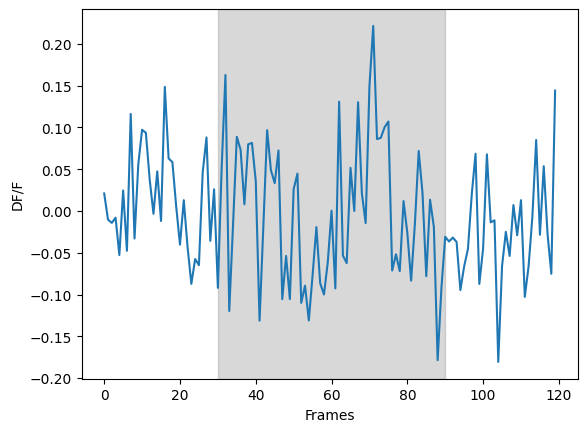

In [ ]:
plt.plot(dff_trace[stim_table.start[0]-30:stim_table.end[0]+30]) #plot first trial with 30 second padding to start and end
plt.axvspan(30,90, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented
plt.ylabel("DF/F")
plt.xlabel("Frames")

We want to quantify this response. There are different methods of quantifying this that you can explore:
* mean DF/F during the grating presentation
* sum of the DF/F during the grating presentation (are these different?)
* maximum DF/F during grating

Do you have other ideas for how to quantify this response?

For now let's use the mean DF/F during the presentation of the grating.

In [ ]:
dff_trace[stim_table.start[0]:stim_table.end[0]].mean()

-0.0020014683

# **Exercise 1:**
Repeat this for the next grating stimulus: plot the dff during the next trial and calculate the mean DF/F.

Text(0.5, 0, 'Frames')

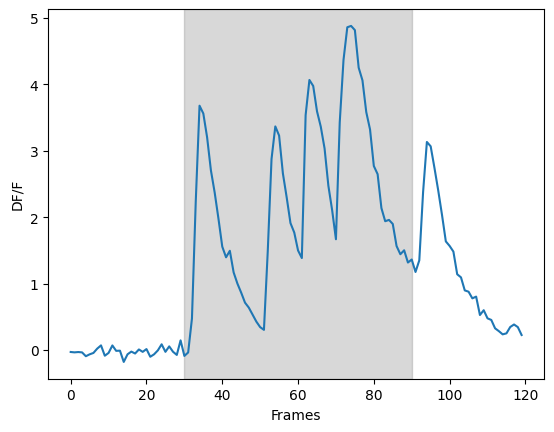

In [ ]:
#@title Click to see solution {display-mode: "form" }
plt.plot(dff_trace[stim_table.start[1]-30:stim_table.end[1]+30])
plt.axvspan(30,90, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented
plt.ylabel("DF/F")
plt.xlabel("Frames")

In [ ]:
#@title Click to see solution {display-mode: "form" }
dff_trace[stim_table.start[1]:stim_table.end[1]].mean()

2.292613

Already we can see that some stimulus conditions elicit larger responses than others.  This is what we want to quantify and summarize in a <b>tuning curve</b>.

<p>To do this, let's calculate the mean DF/F for each grating presentation in this stimulus. To start, let's create a numpy array to hold our calculated responses for all of the trials. We'll have three columns, one for the stimulus orientation, one for the stimulus temporal frequency, and the last for the cell's response. Then we need to iterate over all stimulus trials, populate the orientation and TF and then calculate the mean response.
    

# Task:
Create the cell_response array

In [ ]:
cell_response= np.zeros((len(stim_table),3)) #create an array to hold our data
for i in range(len(stim_table)): #iterate across every trial
    cell_response[i,0] = #fill in to get the orientation of the trial
    cell_response[i,1] = #fill in to get the temporal frequency of the trial
    cell_response[i,2] = #fill in to get the mean response of the neuron to that trial

In [10]:
#@title Click to see solution {display-mode: "form" }
cell_response= np.zeros((len(stim_table),3))
for i in range(len(stim_table)):
    cell_response[i,0] = stim_table.orientation[i]
    cell_response[i,1] = stim_table.temporal_frequency[i]
    cell_response[i,2] = dff_trace[stim_table.start[i]:stim_table.end[i]].mean()

We can check our work by comparing the first two trials to what we had above to make sure they match:

In [11]:
print(cell_response[0,2])
print(cell_response[1,2])

-0.002001468325033784
2.2926130294799805


Now that we've calculated the response for each trial, we can look at how these responses relate to the stimulus parameters.
If we only care about one stimulus parameter, we can quickly compare the response to that parameter, say the direction. Here we will plot each grating response as a function of the grating orientation. (The stimulus table sadly uses "orientation" as the column title when it should be "direction")

Text(0, 0.5, 'Mean DF/F')

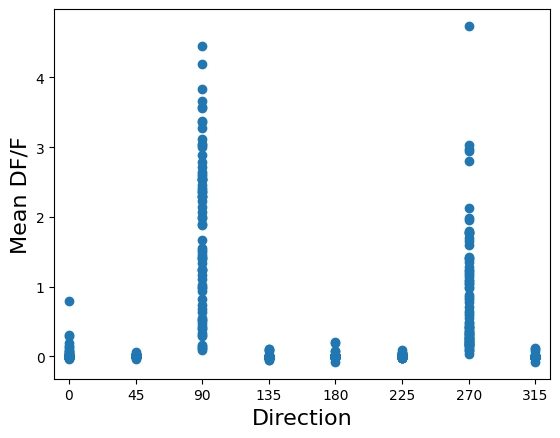

In [ ]:
plt.plot(cell_response[:,0], cell_response[:,2], 'o') #plot each trial's computed response as a function of the trial's orientation

#label axes
plt.xticks(range(0,360,45))
plt.xlim(-10,325)
plt.xlabel("Direction", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

What do we see here?

# **Exercise 2:**
Repeat this for the temporal frequency parameter

Text(0, 0.5, 'Mean DF/F')

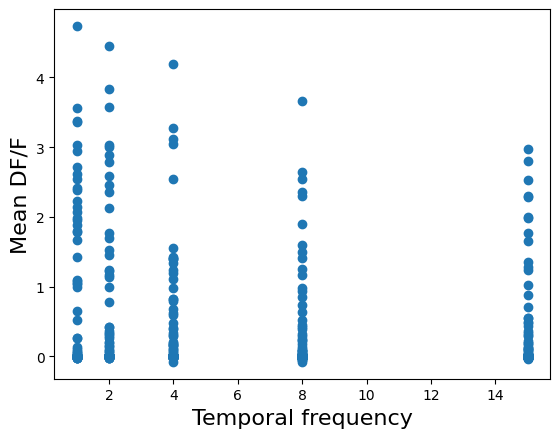

In [ ]:
#@title Click to see solution {display-mode: "form" }
plt.plot(cell_response[:,1], cell_response[:,2], 'o')
plt.xlabel("Temporal frequency", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

We can already glean some things from these plots, but there are a lot of overlapping data points here that make it hard to know exactly what's going on here.

To quantify the relationships between stimulus orientation parameters and response more explicitly let's average all of the responses to each orientation together. This is the mean DF/F response to one orientation, for all temporal frequencies, for all trials.  For example, for orientation=270:

In [12]:
#Find the trials where the orientation is 270
trials = cell_response[:,0]==270
#Average the mean DF/F of just those trials together
cell_response[trials,2].mean()

0.9247032543023427

Let's compute and plot the mean response as a function of orientation (averaged across all temporal frequencies).
    
<p> To start, we need to know what all the possible orientation values are. We need to identify the <b>unique</b> values that are not NaNs (e.g. values that are <b>finite</b>)

In [13]:
all_ori = np.unique(cell_response[:,0]) #find unique values of the orientation column
orivals = all_ori[np.isfinite(all_ori)] #find finite values of the orientations
print(orivals)

[  0.  45.  90. 135. 180. 225. 270. 315.]


Now let's make an array with the average response of all trials for each of these orientations.
    
<p> We can use <b>enumerate</b> to iterate over the orientations in our list. Let me show you the syntax for enumerate. It iterates across the object and returns both the iterator (i.e. the index) and the value for each iteration.

<p> Always remember that if you don't understand a python function you can use ? to get the docstring to help you understand it.

In [ ]:
? enumerate

In [ ]:
for i, ori in enumerate(orivals):
    print(i, ori)

0 0.0
1 45.0
2 90.0
3 135.0
4 180.0
5 225.0
6 270.0
7 315.0


We can now enumerate across orivals to get the trials for each orientation and put the average response for those trials into an array.

In [ ]:
tuning = np.empty((8)) #create an empty array
for i, ori in enumerate(orivals): #enumerate across orientations
    trials = cell_response[:,0]==ori #get the trials when that orientation was used
    tuning[i] = cell_response[trials,2].mean() #average the responses for the trials together and put it into the ith spot in the tuning array

Let's plot this tuning curve of mean response vs orientation.

Text(0, 0.5, 'Mean DF/F')

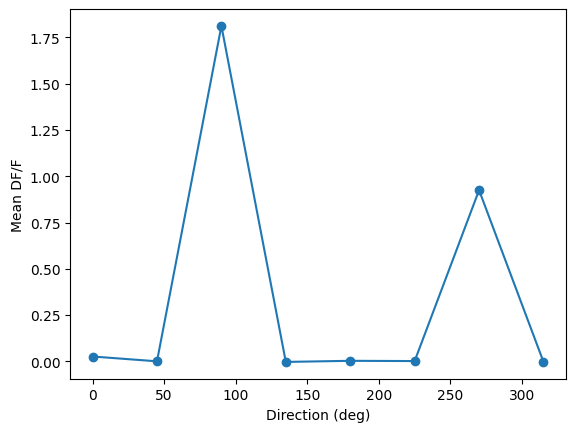

In [ ]:
plt.plot(orivals, tuning, 'o-') #plot tuning vs orivals

#label axes
plt.xlabel("Direction (deg)")
plt.ylabel("Mean DF/F")

# **Exercise 3:**
Compute and plot the mean response as a function of temporal frequency (averaged across all orientations).

tfvals:  [ 1.  2.  4.  8. 15.]


Text(0, 0.5, 'Mean DF/F')

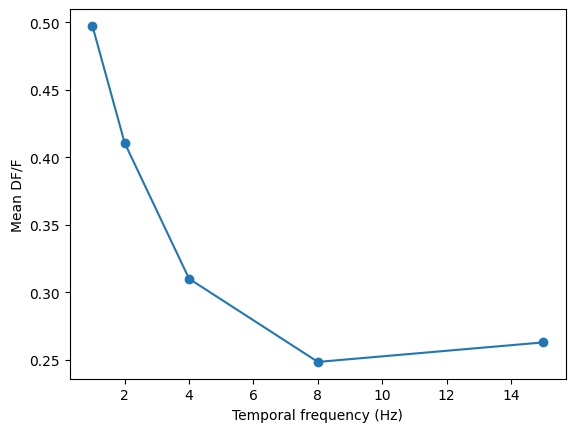

In [14]:
#@title Click to see solution {display-mode: "form" }
tfvals = np.unique(cell_response[:,1])
tfvals = tfvals[np.isfinite(tfvals)]
print("tfvals: ", tfvals)

tuning_tf = np.empty((len(tfvals)))
for i,tf in enumerate(tfvals):
    trials = cell_response[:,1]==tf
    tuning_tf[i] = cell_response[trials,2].mean()

plt.plot(tfvals, tuning_tf, 'o-')
plt.xlabel("Temporal frequency (Hz)")
plt.ylabel("Mean DF/F")

<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
Compare these curves with the plots we made above of all the trials. What do we see now?
</div>

# **Exercise 4:**
Add errorbars to the above tuning curves. They can be standard deviation or standard error or the mean. Make a new array for the tuning values with two columns - one for the mean response and one for the error you decide to use
    
<p>(Hint: for plotting, <b>plt.errorbar</b> will be useful).

Text(0, 0.5, 'Mean DF/F')

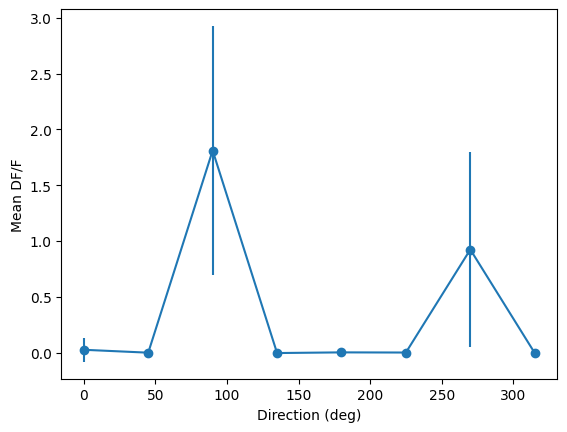

In [15]:
#@title Click to see solution {display-mode: "form" }
tuning = np.empty((8,2))
for i, ori in enumerate(orivals):
    trials = cell_response[:,0]==ori
    tuning[i,0] = cell_response[trials,2].mean()
    tuning[i,1] = cell_response[trials,2].std()

plt.errorbar(orivals, tuning[:,0], yerr=tuning[:,1], fmt='o-')
plt.xlabel("Direction (deg)")
plt.ylabel("Mean DF/F")

# **Exercise 5:**
Add a black line showing the mean response to the blank sweep.
<br>(Hint 1: orientation and temporal frequency are NaN for the blank sweep condition.  Hint 2: <b>plt.axhline</b> is a useful function for adding a horizontal line).

blank sweep mean response:  0.019221892748991477


Text(0, 0.5, 'Mean DF/F')

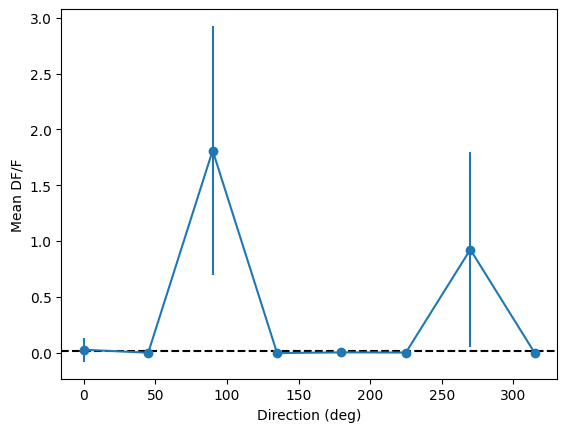

In [16]:
#@title Click to see solution {display-mode: "form" }
blank_trials = np.isnan(cell_response[:,0])
blank_mean = cell_response[blank_trials,2].mean()
print("blank sweep mean response: ", blank_mean)

plt.errorbar(orivals, tuning[:,0], yerr=tuning[:,1], fmt='o-')
plt.axhline(y=blank_mean, ls='--', color='k')
plt.xlabel("Direction (deg)")
plt.ylabel("Mean DF/F")

Why is it important to add these two features?

# **Exercise 6:**
Add the errorbars and blank sweep response to the temporal frequency plot as well

Text(0, 0.5, 'Mean DF/F')

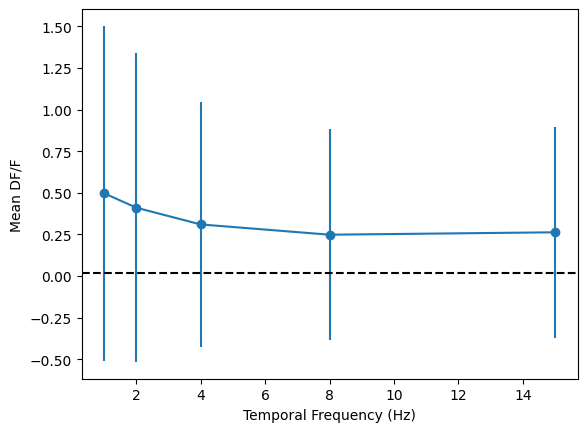

In [18]:
#@title Click to see solution {display-mode: "form" }
tuning_tf = np.empty((len(tfvals), 2))
for i,tf in enumerate(tfvals):
    trials = cell_response[:,1]==tf
    tuning_tf[i,0] = cell_response[trials,2].mean()
    tuning_tf[i,1] = cell_response[trials,2].std()

plt.errorbar(tfvals, tuning_tf[:,0], yerr=tuning_tf[:,1], fmt='o-')
plt.axhline(y=blank_mean, ls='--', color='k')
plt.xlabel("Temporal Frequency (Hz)")
plt.ylabel("Mean DF/F")

# Two dimensional tuning curve
So far we've looked at one stimulus dimension (e.g. orientation) averaged across all conditions of the other (e.g. temporal frequency) - and vice versa. However, it's possible for these two dimensions to interact - so we want to look at these tuning curves for both dimensions simultaneously
<p>To begin, let's compute the two-dimensional tuning array for this neuron - computing the mean response for every possible orientation and temporal frequency combination.

What is the shape of the array we will be computing?

To calculate this we need to enumerate over both temporal frequency and orientation to subselect all the trials for each unique combination of the two:

In [19]:
tuning_array = np.empty((8,5)) # make an array for 8 orientation and 5 temporal frequencies
for i,tf in enumerate(tfvals): # enumerate over tfvals
    tf_trials = cell_response[:,1]==tf # find all the trials for that TF
    subset = cell_response[tf_trials]
    for j,ori in enumerate(orivals): # enumerate over orivals
        trials = subset[:,0]==ori # within the TF subset, find the trials for the Ori
        tuning_array[j,i] = subset[trials,2].mean() #get the mean response for those trials

Let's start by visualizing this similarly to how we did above: Plot the orientation tuning curve for each temporal frequency value as a separate line:

Text(0, 0.5, 'Mean DF/F')

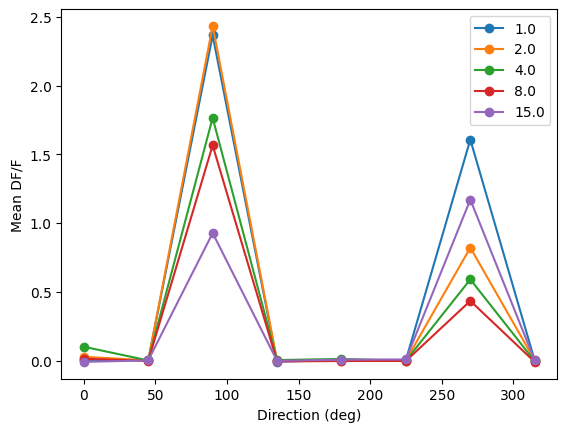

In [20]:
for i, tf in enumerate(tfvals): # for each TF
    plt.plot(orivals, tuning_array[:,i], 'o-', label=tf) #plot the orientation tuning

plt.legend() # add legend

#label axes
plt.xlabel("Direction (deg)")
plt.ylabel("Mean DF/F")


# **Exercise 7:**
Plot each temporal frequency tuning curve for each orientation as a separate line.

Text(0, 0.5, 'Mean DF/F')

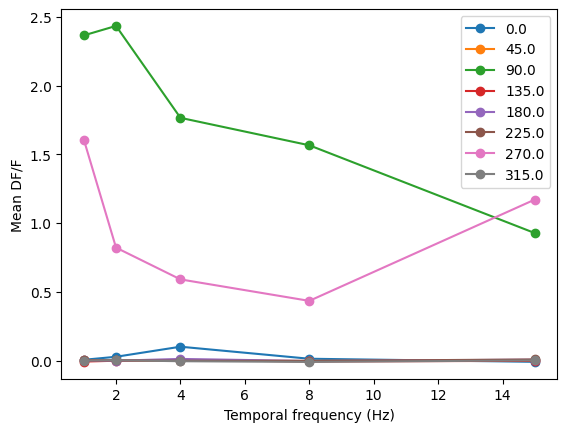

In [21]:
#@title Click to see solution {display-mode: "form" }
for i, ori in enumerate(orivals):
    plt.plot(tfvals, tuning_array[i,:], 'o-', label=ori)
plt.legend()
plt.xlabel("Temporal frequency (Hz)")
plt.ylabel("Mean DF/F")

What do we see here?

Another way to visualize two dimensional data is as a heatmap. Let's use <b>plt.imshow</b> to create this heatmap.

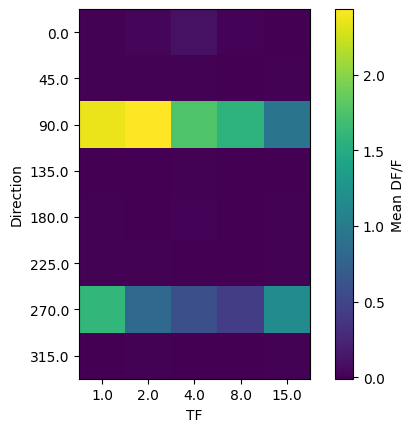

In [22]:
plt.imshow(tuning_array) #plot heatmap

#label axes
plt.xticks(range(5), tfvals)
plt.yticks(range(8), orivals)
plt.xlabel("TF")
plt.ylabel("Direction")

#add colorbar
cbar = plt.colorbar() #Add the colorbar so we know what the colors mean
cbar.set_label("Mean DF/F")

<p>This visualization gives us a great view of how the two dimensions interact, but one disadvantage is that we can't add errorbars or even the blank sweep response to this. But we saw that that information can be important for interpreting what we see in the data.
<p>One approach we can take is to compute the <b>z score</b> where each response is mean subtracted and normalized to the standard deviation. So it shows how far each response deviates from the mean response (rather than the blanksweep response as we plotted above in exercise 5).

In [23]:
tuning_array_z = (tuning_array - tuning_array.mean())/tuning_array.std()

Text(0.5, 1.0, 'Cell 541513979')

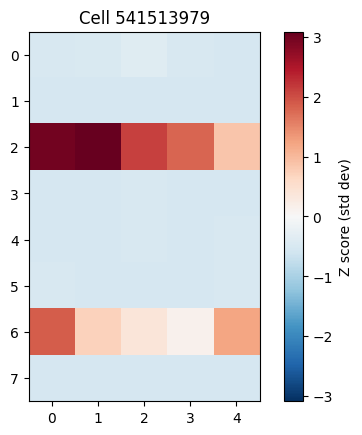

In [25]:
plt.imshow(tuning_array_z, cmap="RdBu_r", vmax=tuning_array_z.max(), vmin=-1*tuning_array_z.max()) #plot heatmap
#note we are using a different color scale here that is centered at 0 - a *diverging color scale*

#add colorbar
cbar = plt.colorbar()
cbar.set_label("Z score (std dev)")
plt.title("Cell "+str(cell_id)) #Add a title so we know what the plot is of